In [2]:
!python -m pip install stellargraph chardet networkx seaborn numpy pandas tqdm gensim scikit-learn

  Using cached stellargraph-1.2.1-py3-none-any.whl (435 kB)
  Using cached chardet-5.2.0-py3-none-any.whl (199 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 5.2 MB/s eta 0:00:00a 0:00:01
  Using cached numpy-1.24.4-cp38-cp38-macosx_10_9_x86_64.whl (19.8 MB)
  Using cached pandas-2.0.3-cp38-cp38-macosx_10_9_x86_64.whl (11.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 3.1 MB/s eta 0:00:00
  Using cached gensim-4.3.2-cp38-cp38-macosx_10_9_x86_64.whl (24.1 MB)
  Using cached scikit_learn-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl (10.1 MB)
  Using cached tensorflow-2.13.1-cp38-cp38-macosx_10_15_x86_64.whl (216.2 MB)
  Using cached scipy-1.10.1-cp38-cp38-macosx_10_9_x86_64.whl (35.0 MB)
  Using cached matplotlib-3.7.5-cp38-cp38-macosx_10_12_x86_64.whl (7.4 MB)
  Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached smart_open-7.0.4

In [8]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm
from functools import reduce
import datetime
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from utils import * 
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter, BiasedRandomWalk, TemporalRandomWalk
from scipy.special import softmax
from tqdm import tqdm
import math
from sklearn.preprocessing import normalize
from math import isclose
from sklearn.decomposition import PCA
import multiprocessing
import sklearn.model_selection 
from gensim.models import Word2Vec
# python3 -m pip install tqdm seaborn 

# CM_Time() & Weekly Graph Construction

In [9]:
class temporalNetwork(): 
    def __init__(self, start_date, end_date, display_progress=False, location_grouping='kma', origin=None, facility_id=None, intermediate=None):
        """ 
        Note: 
            start_date and end_date should be both None as they are used as a signal to 
            CM_Time's run_simulation to whether construct a new graph or update the graph with new information 
        """
        self.display_progress = display_progress
        self.start_date=start_date
        self.end_date=end_date
        self.network=None
        self.origin_location_list=None
        self.location_grouping=location_grouping
        self.inbound_data = None 
        self.outbound_data = None

    def construct_network_graph(self):
        """ 
        Given an inbound and outbound dataframe, construct a network graph and stores it in the class variable self.network
        Args: 
            an_inbound_df (pd.DataFrame): inbound dataframe
            an_outbound_df (pd.DataFrame): outbound dataframe
            start_date (datetime): start date of the network graph
            end_date (datetime): end date of the network graph
            location_grouping(string): 'kma' or 'zip3'
        """
        # pull data & construct an empty multiDiGraph

        date = self.start_date.strftime("%Y-%m-%d") + "_" + self.end_date.strftime("%Y-%m-%d")
        an_inbound_df, an_outbound_df = pd.read_csv(f"inbound_{self.location_grouping}_data/inbound_data_{date}.csv"), pd.read_csv(f"outbound_{self.location_grouping}_data/outbound_data_{date}.csv")
        an_inbound_df.load_date, an_outbound_df.load_date = pd.to_datetime(an_inbound_df.load_date), pd.to_datetime(an_outbound_df.load_date)
        for colin, colout in zip(an_inbound_df.columns, an_outbound_df.columns): 
            if colin not in ["total_loads", "load_date"]: 
                an_inbound_df[colin] = an_inbound_df[colin].astype(str)
            if colout not in ["total_loads", "load_date"]:
                an_outbound_df[colout] = an_outbound_df[colout].astype(str)

        network_graph = nx.MultiDiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # network_graph = nx.DiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # idf, odf = an_inbound_df.copy(), an_outbound_df.copy()

        # idf.to_csv(f"data/inbound_data_{self.start_date}_{self.end_date}.csv", index=False)
        # odf.to_csv(f"data/outbound_data_{self.start_date}_{self.end_date}.csv", index=False)

        # add nodes & edges 
        node_1 = f"origin_{self.location_grouping}_id"
        node_2 = f"facility_{self.location_grouping}_id"
        node_3 = f"destination_{self.location_grouping}_id"

        network_graph = add_nodes_given_df(network_graph, an_inbound_df, [node_1, 'facility_id']) 
        network_graph = add_nodes_given_df(network_graph, an_outbound_df, ['facility_id', node_2, node_3]) 

        network_graph = add_edges_given_graph(network_graph, an_inbound_df, an_outbound_df, self.location_grouping)
        
        # update the variables 
        self.network = network_graph
        self.origin_location_list = an_inbound_df[f'origin_{self.location_grouping}_id'].unique()
        self.inbound_data, self.outbound_data = an_inbound_df, an_outbound_df
        if self.display_progress: print(f"Current time of the graph: {self.start_date} to {self.end_date}") 
        
    def move_to_next_week(self): 
        """ 
        Given the new week's inbound and outbound dataframes, 
        update self.network graph, self.start_date, and self.end_date to a week after current start date and end date 
        
        Args:
            next_inbound_df (pd.DataFrame): new week's inbound dataframe
            next_outbound_df (pd.DataFrame): new week's outbound dataframe
            display_progress (boolean): whether to display the progress of the function or not
        """
        # update the dates, pull new week's data, & store some informations
        self.start_date, self.end_date = self.start_date + timedelta(days=7), self.end_date + timedelta(days=7)
        date = self.start_date.strftime("%Y-%m-%d") + "_" + self.end_date.strftime("%Y-%m-%d")
        next_inbound_df, next_outbound_df = pd.read_csv(f"inbound_{self.location_grouping}_data/inbound_data_{date}.csv"), pd.read_csv(f"outbound_{self.location_grouping}_data/outbound_data_{date}.csv")
        next_inbound_df.load_date, next_outbound_df.load_date = pd.to_datetime(next_inbound_df.load_date), pd.to_datetime(next_outbound_df.load_date)
        for colin, colout in zip(next_inbound_df.columns, next_outbound_df.columns): 
            if colin not in ["total_loads", "load_date"]: 
                next_inbound_df[colin] = next_inbound_df[colin].astype(str)
            if colout not in ["total_loads", "load_date"]:
                next_outbound_df[colout] = next_outbound_df[colout].astype(str)

        network_graph = nx.MultiDiGraph(name=f"new network", start_date=self.start_date, end_date=self.end_date)
        # network_graph = nx.DiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # idf, odf = an_inbound_df.copy(), an_outbound_df.copy()

        # idf.to_csv(f"data/inbound_data_{self.start_date}_{self.end_date}.csv", index=False)
        # odf.to_csv(f"data/outbound_data_{self.start_date}_{self.end_date}.csv", index=False)

        # add nodes & edges 
        node_1 = f"origin_{self.location_grouping}_id"
        node_2 = f"facility_{self.location_grouping}_id"
        node_3 = f"destination_{self.location_grouping}_id"

        network_graph = add_nodes_given_df(network_graph, next_inbound_df, [node_1, 'facility_id']) 
        network_graph = add_nodes_given_df(network_graph, next_outbound_df, ['facility_id', node_2, node_3]) 

        network_graph = add_edges_given_graph(network_graph, next_inbound_df, next_outbound_df, self.location_grouping)

         # update the variables 
        self.network = network_graph
        self.origin_location_list = next_inbound_df[f'origin_{self.location_grouping}_id'].unique()
        self.inbound_data, self.outbound_data = next_inbound_df, next_outbound_df
        if self.display_progress: print(f"Current time of the graph: {self.start_date} to {self.end_date}") 
       

    def print_network_information(self, given_network, print_network_time=False): 
        """
        Given a network, print out the information of the network
        Args: 
            given_network (nx.MultiDiGraph): a network graph
        Returns: N/A
        """
        print("---------------------------------------------------------------------------------------------") 
        print(given_network)
        print(f"Is the given network a DAG for load_network?: {nx.is_directed_acyclic_graph(given_network)}")
        print(f"Number of self loops: {nx.number_of_selfloops(given_network)}")
        if print_network_time: print(f"Current time of the graph: {given_network.graph['start_date']} to {given_network.graph['end_date']}")
        else: print(f"Current time of the graph: {self.start_date} to {self.end_date}")


In [10]:
class CM_Finder():
    def __init__(self, location_grouping='kma', origin_location_list=None, network = None):
        self.network=network
        self.processed_network=None
        self.processed=False 
        self.origin_location_list=origin_location_list
        self.match_failure = None
        self.remove_failure = 0
        self.location_grouping=location_grouping
        
    def group_to_DiGraph(self, display_progress = False):
        """
        #TODO: explain why aggregate_faciility_zip then group_to_DiGraph (kma-> facility_zip -> kma to kma->kma->kma, aggregate to faciliy KMA)
        Assuming that self.network is constructed, 
        sums the edge weights for edges with the same nodes in self.network variable and 
        stores the new graph with aggregated edges in self.processed_network variable and returns False if successful 

        Args:
            display_progress (boolean): whether to display the progress of the function or not

        NOTE) disregards temporal factor 
        """
        if not self.network: 
            print("Please construct the network first")
            return None 
            
        new_name = self.network.name + " reduced"
        self.processed_network = nx.DiGraph(name=new_name)
        self.processed_network.add_nodes_from(self.network)

        if display_progress: print("Aggregating nodes by KMA...")
        for n1, n2 in self.network.edges():
            sum = 0 
            for inner_dict in self.network.get_edge_data(n1, n2).values(): 
                sum += inner_dict['capacity']
            self.processed_network.add_edge(n1, n2, capacity = sum)
        
        nx.set_edge_attributes(self.processed_network, to_integer(self.network.graph['end_date']), 'time')
        self.processed = True

In [11]:
class CM_Time(): 
    def __init__(self, location_grouping='kma', origin=None, facility_id=None, intermediate=None): 
        self.start_date=None
        self.end_date=None
        self.cm_network = None   
        self.cm_finder = None
        self.origin=origin
        self.facility_id=facility_id
        self.intermediate=intermediate
        self.location_grouping = location_grouping
        self.weekly_graphs = {}
    
    def update_dates(self): 
        """
        Updates the start and end date by 7 days
        """ 
        self.start_date += timedelta(days=7)
        self.end_date += timedelta(days=7)

    def construct_or_update_tg(self, filter_key='load_count', display_progress=False, display_path_info=False):
        """ 
        Either (1) creates a network graph given a start and end date 
            or (2) updates the network graph to the next week's graph 

        Args: 
            start_date, end_date: start & end date of the first two weeks of the simulation

        Returns: n/a
        """        
        # construct or update cm_finder.network 
        if not self.cm_network: 
            self.cm_network = temporalNetwork(self.start_date, self.end_date, display_progress, self.location_grouping, self.origin, self.facility_id, self.intermediate)
            self.cm_network.construct_network_graph()
            self.cm_finder = CM_Finder(location_grouping=self.location_grouping)
        else: 
            self.cm_network.move_to_next_week()

        self.cm_finder.origin_location_list = self.cm_network.origin_location_list
        self.cm_finder.network = self.cm_network.network
        
        # self.cm_finder.group_to_DiGraph(display_progress = display_progress)
        self.weekly_graphs[self.end_date] = self.cm_finder.network

    def temporal_query(self, start_date, temporal=True, looback = 7, number_of_weeks=None, termination_date = None, \
                    filter_key = "load_count", display_progress=False, display_path_info = False): 
        """
        Given a start date, run the simulation for number_of_weeks or until termination_date is reached.

        Args: 
            start_date: start date of the first week of the simulation
            temporal: if True, run the simulation for every two weeks, if False, run the simulation from start_date until end_date
            number_of_weeks: number of weeks to run the simulation for
            termination_date: date to stop the simulation
            filter_key: key to filter the network on (load_count or path_score)
            display_progress: if True, display progress bar
            display_path_info: if True, display path info

        Returns: a dictionary of simulation result for each week
            
        Note:
        * termination_date: termination date of the entire analysis, when end_date reaches termination_date, the query loop terminates,
        * end_date: the end date of the two-week window, will be updated every week

        - Once the parameters (location_grouping, origin, facility_id, intermediate) are used to initialise the cm_time class, 
          they will be used for any further analysis until new initialisation happens.
          query_weekly method will only perform analysis, no alterations can be made by calling solely this.

        - If temporal=True, --> end_date != termination_date, eventually at the end of simulations, end_date = termination_date
            and number_of_weeks is given, end_date = start_date + 13 days for the first simulation, termination_date = start_date + 7 days * number_of_weeks
            and termination_date is given, end_date = start_date + 13 days for the first simulation and termination_date=termination_date for the simulation
          If temporal=False --> end_date = termination_date 
            and number_of_weeks is given, end_date = start_date + 7 days * number_of_weeks for the simulation 
            and termination_date is given, end_date=termination_date for the simulation

        * simulation_results: a dictionary with key as the end_date and value as the simulation result
        """

        # create information needed for a new query with the given start_date and number_of_weeks
        # possible bug when end_date > termination_date.
        if temporal: 
            self.start_date, self.end_date = start_date, start_date + timedelta(days=looback-1)

            if number_of_weeks: termination_date = self.start_date + timedelta(days=7) * number_of_weeks
            elif termination_date: termination_date = termination_date
            else: raise Exception("Neither number of weeks nor termination date was given to set the simulation time period.")
        
            # run simulation for every two weeks until termination_date
            while self.end_date <= termination_date:    
                self.construct_or_update_tg(filter_key=filter_key, \
                                    display_progress=display_progress, display_path_info=display_path_info)
                self.update_dates() 
                
        else: 
            if number_of_weeks: self.start_date, self.end_date = start_date, start_date + timedelta(days=7) * number_of_weeks
            elif termination_date: self.start_date, self.end_date = start_date, termination_date
            else: raise Exception("Neither number of weeks nor termination date was given to set the simulation time period.")
            self.run_single_simulation(filter_key=filter_key, \
                                display_progress=display_progress, display_path_info=display_path_info)

        return self.weekly_graphs

    def if_edge(node1, node2, curr_graph): 
        adjacency_matrix = curr_graph

In [12]:
# k1, k2 = list(weekly_graphs.keys())[:2]
# weekly_graphs[k1] == weekly_graphs[k2]

In [15]:
cm_time = CM_Time(location_grouping = 'kma') 
weekly_kma_graphs = cm_time.temporal_query(start_date=datetime(2021,1,1).date(), looback=7, termination_date= datetime(2023,6, 1).date(), \
                    display_progress=False, display_path_info = False)

In [14]:
cm_time = CM_Time(location_grouping = 'zip3') 
weekly_zip3_graphs = cm_time.temporal_query(start_date=datetime(2021,1,1).date(), looback=7, termination_date= datetime(2023,6, 1).date(), \
                    display_progress=False, display_path_info = False)

# Link Prediction Algorithm

In [16]:
def operator_l2(u, v):
    return (u - v) ** 2

def operator_sub(u, v):
    return (u - v)

binary_operator = operator_l2

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


def edge_to_features(link_examples, transform_node):
    return [
        operator_l2(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]

def link_examples_to_features_sub(link_examples, transform_node):
    return [
        operator_sub(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]

def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter, penalty="l2") #, solver="liblinear")
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


In [17]:
def temporal_model(graph, num_walks_per_node=10, walk_length = 10, context_window_size = 2): 
    num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)
    temporal_rw = TemporalRandomWalk(graph)
    temporal_walks = temporal_rw.run(
        num_cw=num_cw,
        cw_size=context_window_size,
        max_walk_length=walk_length,
        walk_bias="exponential",
    )
    
    embedding_size = 128
    temporal_model = Word2Vec(
        temporal_walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        epochs=1,)

    unseen_node_embedding = np.zeros(embedding_size)

    def temporal_embedding(u):
        try:
            return temporal_model.wv[u]
        except KeyError:
            return unseen_node_embedding
    return temporal_embedding 

In [18]:
def data_split(graph, prediction_window_size=2, test_neg_size=None): 
    # identify first 5 & last 2 days' edges based on dates
    edges, weights = np.array(graph.edges(include_edge_weight=True)[0]), np.array(graph.edges(include_edge_weight=True)[1])
    lower_lim = sorted(list(set(weights)))[-prediction_window_size]
    index_test, index_train = np.where(weights >= lower_lim)[0], np.where(weights < lower_lim)[0]

    # create test & train edge sets
    test_pos_edges, test_time_labels = edges[index_test], weights[index_test]
    train_edges, train_time_labels = edges[index_train], weights[index_train]
    # test_pos_edges_with_time_attribute = np.rec.fromarrays([test_pos_edges[:,0], test_pos_edges[:,1], test_time_labels])
    train_edges_with_time_attribute = np.rec.fromarrays([train_edges[:,0], train_edges[:,1], train_time_labels])

    # create test and train graph 
    train_graph = nx.MultiDiGraph()
    train_graph.add_weighted_edges_from(train_edges_with_time_attribute,weight='time') 

    # create pos & neg edges for test graph 
    if not test_neg_size: 
        n = len(test_pos_edges) 
    else: 
        n = len(test_pos_edges) * test_neg_size
    test_neg_edges = list(nx.non_edges(train_graph)) #take the first x number of non edges
    test_pos_edges_tuple = [tuple(x) for x in test_pos_edges]
    test_neg_edges = np.array(list(set(test_neg_edges) - set(test_pos_edges_tuple)))[:n]
    test_edges = np.vstack((test_pos_edges, test_neg_edges))
    test_labels = np.hstack((np.ones(len(test_pos_edges)), np.zeros(len(test_neg_edges))))
    
    ## create train & validating edge sets from train graph 
    train_graph = StellarGraph.from_networkx(train_graph, edge_weight_attr='time', edge_type_attr='directed')
    edge_splitter_train = EdgeSplitter(train_graph, graph)
    graph_train, examples, labels = edge_splitter_train.train_test_split(
        p=0.1, method="global"
    )
    return test_edges, test_labels, graph_train, examples, labels

def random_walk_model(graph, num_walks_per_node=10, walk_length = 10, context_window_size = 2, temporal=True): 
    num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)
    if temporal: 
        rw_model = TemporalRandomWalk(graph)
        walks = rw_model.run(
        num_cw=num_cw,
        cw_size=context_window_size,
        max_walk_length=walk_length,
        walk_bias="exponential",
        )

    else: 
        rw_model = BiasedRandomWalk(graph)
        walks = rw_model.run(
        nodes=graph.nodes(), n=num_walks_per_node, length=walk_length
        )
    
    embedding_size = 128
    node_embedding = Word2Vec(
        walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        epochs=1,)

    unseen_node_embedding = np.zeros(embedding_size)

    def get_node_embedding(u):
        try:
            return node_embedding.wv[u]
        except KeyError:
            return unseen_node_embedding
    return get_node_embedding 

In [19]:
from collections import defaultdict
class WeeklyDecisionMaker():
    def __init__(self, num_walks_per_node=10, walk_length = 10, context_window_size=2, expert_num=10):
        # needed for temporal embedding
        self.num_walks_per_node = num_walks_per_node
        self.walk_length = walk_length
        self.context_window_size = context_window_size

        # weight optimization
        self.naive_regret = 0
        self.past_naive_regrets = defaultdict(list)
        self.graph = None 
        self.expert_num = expert_num
        self.hedge_total_regret = [0]
        self.naive_total_regret = [0]

        # record purposes 
        self.test_edges = []
        self.test_edge_labels = []
        # self.curr_false_positive_set = set()
        self.train_scores = []
        self.test_scores = []
        self.predicted_probs = [] 
        self.weight_vectors= defaultdict(list)

    def initialize_dictionaries(self, edge_tuple): 
        self.weight_vectors[edge_tuple] = [1/self.expert_num] * self.expert_num
        
    def fit_classifier(self, embeddings, labels):
        temporal_clf = link_prediction_classifier()
        temporal_clf.fit(embeddings, labels)
        return temporal_clf

    def evaluate_score(self, clf, link_features, link_labels, threshold= 0.5, return_idces=False):
        self.predicted_probs = clf.predict_proba(link_features)
        positive_column = list(clf.classes_).index(1)
        if return_idces: 
            false_positive_idces = np.where((link_labels == 0) & (self.predicted_probs[:, positive_column] > threshold))[0]
            # true_positive_idces = np.where((link_labels == 1) & (predicted[:, positive_column] > 0.5))[0]
            return roc_auc_score(link_labels, self.predicted_probs[:, positive_column]), false_positive_idces #, true_positive_idces
        return roc_auc_score(link_labels, self.predicted_probs[:, positive_column])

    def update_curr_false_positive(self, new_edge_set, display_progress=False): 
        not_false_positive_anymore = self.curr_false_positive_set.intersection(new_edge_set)
        if display_progress: print(f"Not false positive anymore: {len(not_false_positive_anymore)}")
        if not_false_positive_anymore: 
            self.naive_regret -= len(not_false_positive_anymore)
            self.curr_false_positive_set = self.curr_false_positive_set - not_false_positive_anymore
            if display_progress: print(f"New Reduced Regret: {len(self.curr_false_positive_set)}")            

    def predict_probs(self, graph, display_progress=False, temporal=True): 
        # update regret by checking if they are in the new graph just given  
        # self.update_curr_false_positive(set(graph.edges()), display_progress=display_progress)

        # convert networkx graph to stellargraph & split data
        graph = StellarGraph.from_networkx(graph, edge_weight_attr='time', edge_type_attr='directed')
        links_test, labels_test, train_graph, links_validate, labels_validate = data_split(graph)
        self.test_edges, self.test_edge_labels = links_test, labels_test

        # fit & learn 
        node_embedding = random_walk_model(train_graph, 
                            num_walks_per_node=self.num_walks_per_node, walk_length=self.walk_length, \
                            context_window_size=self.context_window_size, temporal= temporal)
        edge_embedding_train = edge_to_features(links_validate, node_embedding)
        fitted_classifier = self.fit_classifier(edge_embedding_train, labels_validate) #fit classifier
        train_score = self.evaluate_score(fitted_classifier, edge_embedding_train, labels_validate)
        self.train_scores.append(train_score)

        # compute probability of potential edges  
        edge_embedding_test = edge_to_features(links_test, node_embedding)       
        test_score, false_positive_idces = self.evaluate_score(fitted_classifier, edge_embedding_test, labels_test, return_idces=True)
        self.test_scores.append(test_score)
        if display_progress: print(f"Temporal Test Score (ROC AUC): {test_score:.2f}")
        
    def optimize_weights_for_edge(self, learning_rate=0.1, leader_thresholds = np.arange(0.1, 1.1, 0.1)): 
        self.hedge_total_regret.append(self.hedge_total_regret[-1])
        self.naive_total_regret.append(self.naive_total_regret[-1])

        # update regret for all test edges, keep track of weight vectors per edge 
        for edge_index, edge in enumerate(self.test_edges): 
            edge_tuple = tuple(edge)
            if edge_tuple not in self.weight_vectors.keys(): 
                self.initialize_dictionaries(edge_tuple)
            edge_existence = self.test_edge_labels[edge_index]
            edge_existence_prob = self.predicted_probs[edge_index,1] 
            self.hedge_per_edge(edge_tuple, edge_existence_prob, edge_existence, learning_rate, leader_thresholds)

    def hedge_per_edge(self, edge_tuple, edge_existence_prob, edge_existence, learning_rate = 0.1, leader_thresholds = np.arange(0.1, 1.1, 0.1)):
        wait_leaders = [1 if edge_existence_prob > threshold else 0 for threshold in leader_thresholds]
        not_wait_leaders = [1 if edge_existence_prob < threshold else 0 for threshold in leader_thresholds]
        weight_vector = self.weight_vectors[edge_tuple]

        # make decision based on each leader's recommendation & weight vector
        final_wait_decision = True if np.dot(wait_leaders, weight_vector) > np.dot(not_wait_leaders, weight_vector) else False 
        naive_decision = True if edge_existence_prob > 0.5 else False

        # record regret by checking if they are in the new graph & update weight 
        leader_made_wrong_decision = [1 if wait_decision != edge_existence  else 0 for wait_decision in wait_leaders]
        loss = 0
        if final_wait_decision != edge_existence:
            if final_wait_decision == 1: 
                loss = 3 #false positive treated most harshly 
            else: loss = 1 #false negative treated less harshly
        else: 
            leader_made_wrong_decision = [-1 * wrong_decision for wrong_decision in leader_made_wrong_decision]
            if final_wait_decision == 1: 
                loss = -2 #true positive rewarded most  
            else: loss = -1 #true negative rewarded second most

        weight_vector = [weight_i * np.exp(-learning_rate * loss * wrong_decision) for wrong_decision, weight_i in zip(leader_made_wrong_decision, weight_vector)]        
        weight_vector = weight_vector/ np.sum(weight_vector) # renormalize weight_vector 
        self.weight_vectors[edge_tuple] = weight_vector
        self.hedge_total_regret[-1] += loss
        
        # update naive regret 
        curr_naive_loss = 0
        if naive_decision != edge_existence: 
            if final_wait_decision == 1: 
                curr_naive_loss = 3 #false positive treated most harshly 
            else: curr_naive_loss = 1 #false negative treated less harshly
        else: 
            if naive_decision == 1: 
                curr_naive_loss = -2 #true positive rewarded most
            else: curr_naive_loss = -1 #true negative rewarded second most

        self.naive_total_regret[-1] += curr_naive_loss

    def run_expert_simulation(self, graph, learning_rate=0.1, temporal=True, display_progress=False):
        self.predict_probs(graph, display_progress=display_progress, temporal=temporal)
        self.optimize_weights_for_edge(learning_rate=learning_rate)
        if display_progress: self.print_info_given_week(graph.graph['end_date'])
        
    def print_info_given_week(self, curr_time): 
        print("--------------------------------------------------")
        print(f"Current Week: {curr_time}")
        # print(f"training error: {np.round(self.train_errors[-1],2)}, test error: {np.round(self.test_errors[-1],2)}")
        print(f"Total Number of Test Edges: {len(self.test_edges)}")
        print(f"Current Expert Regret: { self.hedge_total_regret[-1]}")
        print(f"Current Naive Regret: {self.naive_total_regret[-1]}")
        print("--------------------------------------------------")

    def graph_train_test_errors(self, time_range, graph_errors = True, graph_regret = False, title=None): 
        n = min(len(self.train_errors), len(self.test_errors))
        if title: plt.title(title)
        if graph_errors: 
            # plt.plot(time_range[:n], self.train_errors[:n], label='train')
            plt.plot(time_range[:n], self.test_errors[:n], label='test')
        if graph_regret: 
            plt.plot(time_range[:n], self.curr_regret[:n], label='regret')
        plt.legend() 
        plt.tight_layout()
        plt.show()


1. given a route, are we doing this? 
2. or are we doing this for the entire graph? 

Since we are making the prediction on all potential edges for a graph, how would we do this..?

In [20]:
temporal_zip3_dm = WeeklyDecisionMaker()
for graph in tqdm(weekly_zip3_graphs.values()):
    temporal_zip3_dm.run_expert_simulation(graph, display_progress=True)

  0%|          | 0/126 [00:00<?, ?it/s]

** Sampled 336 positive and 336 negative edges. **


  1%|          | 1/126 [00:11<23:07, 11.10s/it]

Temporal Test Score (ROC AUC): 0.85
--------------------------------------------------
Current Week: 2021-01-07
Total Number of Test Edges: 2666
Current Expert Regret: -1475
Current Naive Regret: -2008
--------------------------------------------------
** Sampled 474 positive and 474 negative edges. **


  2%|▏         | 2/126 [00:21<22:03, 10.67s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-01-14
Total Number of Test Edges: 2508
Current Expert Regret: -3106
Current Naive Regret: -3724
--------------------------------------------------
** Sampled 352 positive and 352 negative edges. **


  2%|▏         | 3/126 [00:32<22:09, 10.81s/it]

Temporal Test Score (ROC AUC): 0.83
--------------------------------------------------
Current Week: 2021-01-21
Total Number of Test Edges: 5422
Current Expert Regret: -7336
Current Naive Regret: -7975
--------------------------------------------------
** Sampled 355 positive and 355 negative edges. **


  3%|▎         | 4/126 [00:44<22:40, 11.16s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2021-01-28
Total Number of Test Edges: 5136
Current Expert Regret: -11031
Current Naive Regret: -11413
--------------------------------------------------
** Sampled 328 positive and 328 negative edges. **


  4%|▍         | 5/126 [00:54<22:10, 11.00s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-02-04
Total Number of Test Edges: 4950
Current Expert Regret: -14961
Current Naive Regret: -14657
--------------------------------------------------
** Sampled 492 positive and 492 negative edges. **


  5%|▍         | 6/126 [01:06<22:32, 11.27s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-02-11
Total Number of Test Edges: 2576
Current Expert Regret: -17036
Current Naive Regret: -16493
--------------------------------------------------
** Sampled 402 positive and 402 negative edges. **


  6%|▌         | 7/126 [01:16<21:41, 10.94s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-02-18
Total Number of Test Edges: 1920
Current Expert Regret: -18652
Current Naive Regret: -17807
--------------------------------------------------
** Sampled 491 positive and 491 negative edges. **


  6%|▋         | 8/126 [01:28<21:42, 11.04s/it]

Temporal Test Score (ROC AUC): 0.83
--------------------------------------------------
Current Week: 2021-02-25
Total Number of Test Edges: 2868
Current Expert Regret: -21130
Current Naive Regret: -19790
--------------------------------------------------
** Sampled 506 positive and 506 negative edges. **


  7%|▋         | 9/126 [01:38<21:21, 10.95s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-03-04
Total Number of Test Edges: 2692
Current Expert Regret: -23539
Current Naive Regret: -21792
--------------------------------------------------
** Sampled 488 positive and 488 negative edges. **


  8%|▊         | 10/126 [01:49<21:01, 10.88s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-03-11
Total Number of Test Edges: 2800
Current Expert Regret: -26052
Current Naive Regret: -23813
--------------------------------------------------
** Sampled 491 positive and 491 negative edges. **


  9%|▊         | 11/126 [02:00<20:41, 10.80s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-03-18
Total Number of Test Edges: 2910
Current Expert Regret: -28810
Current Naive Regret: -25875
--------------------------------------------------
** Sampled 516 positive and 516 negative edges. **


 10%|▉         | 12/126 [02:10<20:24, 10.74s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-03-25
Total Number of Test Edges: 2760
Current Expert Regret: -31552
Current Naive Regret: -27687
--------------------------------------------------
** Sampled 362 positive and 362 negative edges. **


 10%|█         | 13/126 [02:20<19:48, 10.51s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-04-01
Total Number of Test Edges: 5430
Current Expert Regret: -37595
Current Naive Regret: -30609
--------------------------------------------------
** Sampled 478 positive and 478 negative edges. **


 11%|█         | 14/126 [02:31<19:53, 10.66s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2021-04-08
Total Number of Test Edges: 2752
Current Expert Regret: -40336
Current Naive Regret: -32399
--------------------------------------------------
** Sampled 497 positive and 497 negative edges. **


 12%|█▏        | 15/126 [02:42<19:44, 10.67s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-04-15
Total Number of Test Edges: 2712
Current Expert Regret: -43062
Current Naive Regret: -34258
--------------------------------------------------
** Sampled 344 positive and 344 negative edges. **


 13%|█▎        | 16/126 [02:52<19:21, 10.56s/it]

Temporal Test Score (ROC AUC): 0.84
--------------------------------------------------
Current Week: 2021-04-22
Total Number of Test Edges: 5444
Current Expert Regret: -48927
Current Naive Regret: -37756
--------------------------------------------------
** Sampled 345 positive and 345 negative edges. **


 13%|█▎        | 17/126 [03:03<19:03, 10.49s/it]

Temporal Test Score (ROC AUC): 0.83
--------------------------------------------------
Current Week: 2021-04-29
Total Number of Test Edges: 5504
Current Expert Regret: -55120
Current Naive Regret: -41058
--------------------------------------------------
** Sampled 467 positive and 467 negative edges. **


 14%|█▍        | 18/126 [03:13<18:37, 10.34s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-05-06
Total Number of Test Edges: 2726
Current Expert Regret: -58218
Current Naive Regret: -42903
--------------------------------------------------
** Sampled 474 positive and 474 negative edges. **


 15%|█▌        | 19/126 [03:23<18:28, 10.36s/it]

Temporal Test Score (ROC AUC): 0.83
--------------------------------------------------
Current Week: 2021-05-13
Total Number of Test Edges: 2622
Current Expert Regret: -61399
Current Naive Regret: -44550
--------------------------------------------------
** Sampled 475 positive and 475 negative edges. **


 16%|█▌        | 20/126 [03:34<18:27, 10.44s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2021-05-20
Total Number of Test Edges: 2764
Current Expert Regret: -64647
Current Naive Regret: -46312
--------------------------------------------------
** Sampled 340 positive and 340 negative edges. **


 17%|█▋        | 21/126 [03:44<18:05, 10.34s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-05-27
Total Number of Test Edges: 5552
Current Expert Regret: -71532
Current Naive Regret: -49479
--------------------------------------------------
** Sampled 205 positive and 205 negative edges. **


/Users/yko/Documents/Temporal-Link-Prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yko/Documents/Temporal-Link-Prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2021-06-03
Total Number of Test Edges: 5514
Current Expert Regret: -78355
Current Naive Regret: -51435
--------------------------------------------------
** Sampled 328 positive and 328 negative edges. **


 18%|█▊        | 23/126 [04:08<19:12, 11.19s/it]

Temporal Test Score (ROC AUC): 0.83
--------------------------------------------------
Current Week: 2021-06-10
Total Number of Test Edges: 5302
Current Expert Regret: -84610
Current Naive Regret: -54708
--------------------------------------------------
** Sampled 327 positive and 327 negative edges. **


 19%|█▉        | 24/126 [04:18<18:26, 10.84s/it]

Temporal Test Score (ROC AUC): 0.83
--------------------------------------------------
Current Week: 2021-06-17
Total Number of Test Edges: 5496
Current Expert Regret: -91720
Current Naive Regret: -57775
--------------------------------------------------
** Sampled 468 positive and 468 negative edges. **


 20%|█▉        | 25/126 [04:29<18:04, 10.74s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2021-06-24
Total Number of Test Edges: 2854
Current Expert Regret: -95098
Current Naive Regret: -59433
--------------------------------------------------
** Sampled 500 positive and 500 negative edges. **


 21%|██        | 26/126 [04:39<17:39, 10.60s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2021-07-01
Total Number of Test Edges: 2746
Current Expert Regret: -98489
Current Naive Regret: -60957
--------------------------------------------------
** Sampled 338 positive and 338 negative edges. **


 21%|██▏       | 27/126 [04:49<17:22, 10.53s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2021-07-08
Total Number of Test Edges: 2986
Current Expert Regret: -102266
Current Naive Regret: -62668
--------------------------------------------------
** Sampled 506 positive and 506 negative edges. **


 22%|██▏       | 28/126 [05:00<17:14, 10.55s/it]

Temporal Test Score (ROC AUC): 0.84
--------------------------------------------------
Current Week: 2021-07-15
Total Number of Test Edges: 2728
Current Expert Regret: -105747
Current Naive Regret: -64713
--------------------------------------------------
** Sampled 493 positive and 493 negative edges. **


 23%|██▎       | 29/126 [05:10<16:52, 10.44s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2021-07-22
Total Number of Test Edges: 2790
Current Expert Regret: -109110
Current Naive Regret: -66489
--------------------------------------------------
** Sampled 492 positive and 492 negative edges. **


 24%|██▍       | 30/126 [05:21<16:55, 10.58s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2021-07-29
Total Number of Test Edges: 2788
Current Expert Regret: -112573
Current Naive Regret: -68181
--------------------------------------------------
** Sampled 486 positive and 486 negative edges. **


 25%|██▍       | 31/126 [05:32<16:46, 10.59s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2021-08-05
Total Number of Test Edges: 2800
Current Expert Regret: -116011
Current Naive Regret: -69613
--------------------------------------------------
** Sampled 352 positive and 352 negative edges. **


 25%|██▌       | 32/126 [05:43<16:47, 10.72s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-08-12
Total Number of Test Edges: 5380
Current Expert Regret: -122250
Current Naive Regret: -72903
--------------------------------------------------
** Sampled 357 positive and 357 negative edges. **


 26%|██▌       | 33/126 [05:53<16:20, 10.55s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-08-19
Total Number of Test Edges: 5650
Current Expert Regret: -129321
Current Naive Regret: -76171
--------------------------------------------------
** Sampled 497 positive and 497 negative edges. **


 27%|██▋       | 34/126 [06:03<16:13, 10.59s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-08-26
Total Number of Test Edges: 2722
Current Expert Regret: -132855
Current Naive Regret: -77815
--------------------------------------------------
** Sampled 486 positive and 486 negative edges. **


 28%|██▊       | 35/126 [06:14<16:04, 10.60s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-09-02
Total Number of Test Edges: 2668
Current Expert Regret: -136164
Current Naive Regret: -79570
--------------------------------------------------
** Sampled 363 positive and 363 negative edges. **


 29%|██▊       | 36/126 [06:24<15:44, 10.50s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2021-09-09
Total Number of Test Edges: 2936
Current Expert Regret: -139918
Current Naive Regret: -81136
--------------------------------------------------
** Sampled 506 positive and 506 negative edges. **


 29%|██▉       | 37/126 [06:35<15:38, 10.55s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-09-16
Total Number of Test Edges: 2724
Current Expert Regret: -143346
Current Naive Regret: -82997
--------------------------------------------------
** Sampled 339 positive and 339 negative edges. **


 30%|███       | 38/126 [06:45<15:07, 10.31s/it]

Temporal Test Score (ROC AUC): 0.83
--------------------------------------------------
Current Week: 2021-09-23
Total Number of Test Edges: 5750
Current Expert Regret: -150559
Current Naive Regret: -86256
--------------------------------------------------
** Sampled 498 positive and 498 negative edges. **


 31%|███       | 39/126 [06:55<14:57, 10.32s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-09-30
Total Number of Test Edges: 2776
Current Expert Regret: -153931
Current Naive Regret: -88065
--------------------------------------------------
** Sampled 505 positive and 505 negative edges. **


 32%|███▏      | 40/126 [07:05<14:47, 10.32s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2021-10-07
Total Number of Test Edges: 2752
Current Expert Regret: -157478
Current Naive Regret: -89613
--------------------------------------------------
** Sampled 511 positive and 511 negative edges. **


 33%|███▎      | 41/126 [07:17<15:05, 10.65s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2021-10-14
Total Number of Test Edges: 2926
Current Expert Regret: -161266
Current Naive Regret: -91114
--------------------------------------------------
** Sampled 518 positive and 518 negative edges. **


 33%|███▎      | 42/126 [07:28<15:06, 10.79s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2021-10-21
Total Number of Test Edges: 2954
Current Expert Regret: -164710
Current Naive Regret: -92684
--------------------------------------------------
** Sampled 535 positive and 535 negative edges. **


 34%|███▍      | 43/126 [07:38<14:46, 10.68s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-10-28
Total Number of Test Edges: 3204
Current Expert Regret: -168652
Current Naive Regret: -94749
--------------------------------------------------
** Sampled 508 positive and 508 negative edges. **


 35%|███▍      | 44/126 [07:48<14:20, 10.50s/it]

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2021-11-04
Total Number of Test Edges: 3002
Current Expert Regret: -172312
Current Naive Regret: -96581
--------------------------------------------------
** Sampled 386 positive and 386 negative edges. **


 36%|███▌      | 45/126 [07:58<13:50, 10.26s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-11-11
Total Number of Test Edges: 6136
Current Expert Regret: -179784
Current Naive Regret: -100052
--------------------------------------------------
** Sampled 547 positive and 547 negative edges. **


 37%|███▋      | 46/126 [08:09<13:46, 10.33s/it]

Temporal Test Score (ROC AUC): 0.83
--------------------------------------------------
Current Week: 2021-11-18
Total Number of Test Edges: 3158
Current Expert Regret: -183568
Current Naive Regret: -102096
--------------------------------------------------
** Sampled 531 positive and 531 negative edges. **


 37%|███▋      | 47/126 [08:19<13:32, 10.29s/it]

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2021-11-25
Total Number of Test Edges: 2814
Current Expert Regret: -187191
Current Naive Regret: -103551
--------------------------------------------------
** Sampled 445 positive and 445 negative edges. **


 38%|███▊      | 48/126 [08:29<13:18, 10.24s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-12-02
Total Number of Test Edges: 3124
Current Expert Regret: -191156
Current Naive Regret: -105420
--------------------------------------------------
** Sampled 516 positive and 516 negative edges. **


 39%|███▉      | 49/126 [08:40<13:18, 10.37s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2021-12-09
Total Number of Test Edges: 2692
Current Expert Regret: -194507
Current Naive Regret: -107060
--------------------------------------------------
** Sampled 363 positive and 363 negative edges. **


 40%|███▉      | 50/126 [08:50<13:02, 10.29s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2021-12-16
Total Number of Test Edges: 5704
Current Expert Regret: -201858
Current Naive Regret: -109769
--------------------------------------------------
** Sampled 357 positive and 357 negative edges. **


 40%|████      | 51/126 [08:59<12:38, 10.11s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2021-12-23
Total Number of Test Edges: 5548
Current Expert Regret: -208968
Current Naive Regret: -112756
--------------------------------------------------
** Sampled 196 positive and 196 negative edges. **


/Users/yko/Documents/Temporal-Link-Prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yko/Documents/Temporal-Link-Prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

Temporal Test Score (ROC AUC): 0.85
--------------------------------------------------
Current Week: 2021-12-30
Total Number of Test Edges: 4932
Current Expert Regret: -215598
Current Naive Regret: -114479
--------------------------------------------------
** Sampled 327 positive and 327 negative edges. **


 42%|████▏     | 53/126 [09:21<12:36, 10.36s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2022-01-06
Total Number of Test Edges: 2786
Current Expert Regret: -219228
Current Naive Regret: -115733
--------------------------------------------------
** Sampled 329 positive and 329 negative edges. **


 43%|████▎     | 54/126 [09:30<12:06, 10.09s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2022-01-13
Total Number of Test Edges: 5944
Current Expert Regret: -227173
Current Naive Regret: -117956
--------------------------------------------------
** Sampled 349 positive and 349 negative edges. **


 44%|████▎     | 55/126 [09:40<11:48,  9.97s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2022-01-20
Total Number of Test Edges: 5822
Current Expert Regret: -234879
Current Naive Regret: -120771
--------------------------------------------------
** Sampled 509 positive and 509 negative edges. **


 44%|████▍     | 56/126 [09:50<11:48, 10.13s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2022-01-27
Total Number of Test Edges: 2954
Current Expert Regret: -238719
Current Naive Regret: -122464
--------------------------------------------------
** Sampled 360 positive and 360 negative edges. **


 45%|████▌     | 57/126 [10:01<11:49, 10.28s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2022-02-03
Total Number of Test Edges: 5940
Current Expert Regret: -246304
Current Naive Regret: -125753
--------------------------------------------------
** Sampled 362 positive and 362 negative edges. **


 46%|████▌     | 58/126 [10:12<11:52, 10.47s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2022-02-10
Total Number of Test Edges: 6332
Current Expert Regret: -254396
Current Naive Regret: -129123
--------------------------------------------------
** Sampled 539 positive and 539 negative edges. **


 47%|████▋     | 59/126 [10:23<11:48, 10.58s/it]

Temporal Test Score (ROC AUC): 0.84
--------------------------------------------------
Current Week: 2022-02-17
Total Number of Test Edges: 3046
Current Expert Regret: -258287
Current Naive Regret: -131088
--------------------------------------------------
** Sampled 379 positive and 379 negative edges. **


 48%|████▊     | 60/126 [10:34<11:43, 10.67s/it]

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2022-02-24
Total Number of Test Edges: 6188
Current Expert Regret: -266224
Current Naive Regret: -134062
--------------------------------------------------
** Sampled 372 positive and 372 negative edges. **


 48%|████▊     | 61/126 [10:44<11:35, 10.70s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2022-03-03
Total Number of Test Edges: 6264
Current Expert Regret: -274074
Current Naive Regret: -137438
--------------------------------------------------
** Sampled 377 positive and 377 negative edges. **


 49%|████▉     | 62/126 [10:55<11:23, 10.68s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2022-03-10
Total Number of Test Edges: 6434
Current Expert Regret: -282542
Current Naive Regret: -140458
--------------------------------------------------
** Sampled 369 positive and 369 negative edges. **


 50%|█████     | 63/126 [11:06<11:09, 10.62s/it]

Temporal Test Score (ROC AUC): 0.81
--------------------------------------------------
Current Week: 2022-03-17
Total Number of Test Edges: 6272
Current Expert Regret: -290992
Current Naive Regret: -143585
--------------------------------------------------
** Sampled 375 positive and 375 negative edges. **


 51%|█████     | 64/126 [11:16<10:58, 10.62s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2022-03-24
Total Number of Test Edges: 6538
Current Expert Regret: -299823
Current Naive Regret: -146535
--------------------------------------------------
** Sampled 550 positive and 550 negative edges. **


 52%|█████▏    | 65/126 [11:27<10:51, 10.68s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2022-03-31
Total Number of Test Edges: 3078
Current Expert Regret: -303743
Current Naive Regret: -148460
--------------------------------------------------
** Sampled 523 positive and 523 negative edges. **


 52%|█████▏    | 66/126 [11:39<10:57, 10.97s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2022-04-07
Total Number of Test Edges: 3114
Current Expert Regret: -307734
Current Naive Regret: -149964
--------------------------------------------------
** Sampled 537 positive and 537 negative edges. **


 53%|█████▎    | 67/126 [11:50<10:47, 10.97s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2022-04-14
Total Number of Test Edges: 3044
Current Expert Regret: -311735
Current Naive Regret: -151496
--------------------------------------------------
** Sampled 516 positive and 516 negative edges. **


 54%|█████▍    | 68/126 [12:00<10:28, 10.84s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2022-04-21
Total Number of Test Edges: 3186
Current Expert Regret: -315825
Current Naive Regret: -153194
--------------------------------------------------
** Sampled 374 positive and 374 negative edges. **


 55%|█████▍    | 69/126 [12:11<10:09, 10.69s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-04-28
Total Number of Test Edges: 6390
Current Expert Regret: -324378
Current Naive Regret: -155605
--------------------------------------------------
** Sampled 557 positive and 557 negative edges. **


 56%|█████▌    | 70/126 [12:22<10:05, 10.80s/it]

Temporal Test Score (ROC AUC): 0.82
--------------------------------------------------
Current Week: 2022-05-05
Total Number of Test Edges: 3146
Current Expert Regret: -328480
Current Naive Regret: -157549
--------------------------------------------------
** Sampled 536 positive and 536 negative edges. **


 56%|█████▋    | 71/126 [12:32<09:52, 10.77s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2022-05-12
Total Number of Test Edges: 3216
Current Expert Regret: -332534
Current Naive Regret: -159346
--------------------------------------------------
** Sampled 382 positive and 382 negative edges. **
Temporal Test Score (ROC AUC): 0.79


 57%|█████▋    | 72/126 [12:43<09:43, 10.81s/it]

--------------------------------------------------
Current Week: 2022-05-19
Total Number of Test Edges: 6190
Current Expert Regret: -340617
Current Naive Regret: -161936
--------------------------------------------------
** Sampled 544 positive and 544 negative edges. **


 58%|█████▊    | 73/126 [12:55<09:43, 11.01s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-05-26
Total Number of Test Edges: 3190
Current Expert Regret: -344826
Current Naive Regret: -163376
--------------------------------------------------
** Sampled 223 positive and 223 negative edges. **


/Users/yko/Documents/Temporal-Link-Prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yko/Documents/Temporal-Link-Prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

Temporal Test Score (ROC AUC): 0.75
--------------------------------------------------
Current Week: 2022-06-02
Total Number of Test Edges: 6680
Current Expert Regret: -352803
Current Naive Regret: -165254
--------------------------------------------------


 59%|█████▊    | 74/126 [13:09<10:17, 11.87s/it]

** Sampled 547 positive and 547 negative edges. **


 60%|█████▉    | 75/126 [13:19<09:48, 11.54s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-06-09
Total Number of Test Edges: 3300
Current Expert Regret: -357006
Current Naive Regret: -166970
--------------------------------------------------
** Sampled 538 positive and 538 negative edges. **


 60%|██████    | 76/126 [13:30<09:25, 11.31s/it]

Temporal Test Score (ROC AUC): 0.74
--------------------------------------------------
Current Week: 2022-06-16
Total Number of Test Edges: 3168
Current Expert Regret: -360971
Current Naive Regret: -168084
--------------------------------------------------
** Sampled 517 positive and 517 negative edges. **


 61%|██████    | 77/126 [13:41<09:04, 11.12s/it]

Temporal Test Score (ROC AUC): 0.77
--------------------------------------------------
Current Week: 2022-06-23
Total Number of Test Edges: 3172
Current Expert Regret: -365144
Current Naive Regret: -169476
--------------------------------------------------
** Sampled 374 positive and 374 negative edges. **
Temporal Test Score (ROC AUC): 0.77
--------------------------------------------------
Current Week: 2022-06-30
Total Number of Test Edges: 6386
Current Expert Regret: -373570
Current Naive Regret: -171507
--------------------------------------------------


 62%|██████▏   | 78/126 [13:51<08:44, 10.94s/it]

** Sampled 373 positive and 373 negative edges. **


 63%|██████▎   | 79/126 [14:01<08:23, 10.70s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-07-07
Total Number of Test Edges: 3264
Current Expert Regret: -377712
Current Naive Regret: -173058
--------------------------------------------------
** Sampled 536 positive and 536 negative edges. **


 63%|██████▎   | 80/126 [14:12<08:12, 10.72s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-07-14
Total Number of Test Edges: 3214
Current Expert Regret: -381884
Current Naive Regret: -174446
--------------------------------------------------
** Sampled 377 positive and 377 negative edges. **
Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-07-21
Total Number of Test Edges: 6392
Current Expert Regret: -390456
Current Naive Regret: -176822
--------------------------------------------------


 64%|██████▍   | 81/126 [14:23<08:08, 10.86s/it]

** Sampled 525 positive and 525 negative edges. **


 65%|██████▌   | 82/126 [14:34<07:58, 10.87s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-07-28
Total Number of Test Edges: 3220
Current Expert Regret: -394591
Current Naive Regret: -178411
--------------------------------------------------
** Sampled 544 positive and 544 negative edges. **


 66%|██████▌   | 83/126 [14:45<07:42, 10.75s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-08-04
Total Number of Test Edges: 3002
Current Expert Regret: -398407
Current Naive Regret: -179893
--------------------------------------------------
** Sampled 531 positive and 531 negative edges. **


 67%|██████▋   | 84/126 [14:55<07:30, 10.72s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-08-11
Total Number of Test Edges: 3274
Current Expert Regret: -402749
Current Naive Regret: -181466
--------------------------------------------------
** Sampled 376 positive and 376 negative edges. **


 67%|██████▋   | 85/126 [15:06<07:15, 10.62s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-08-18
Total Number of Test Edges: 6354
Current Expert Regret: -411258
Current Naive Regret: -183008
--------------------------------------------------
** Sampled 531 positive and 531 negative edges. **


 68%|██████▊   | 86/126 [15:17<07:06, 10.66s/it]

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2022-08-25
Total Number of Test Edges: 3142
Current Expert Regret: -415275
Current Naive Regret: -184606
--------------------------------------------------
** Sampled 548 positive and 548 negative edges. **


 69%|██████▉   | 87/126 [15:27<06:58, 10.73s/it]

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2022-09-01
Total Number of Test Edges: 3274
Current Expert Regret: -419441
Current Naive Regret: -186284
--------------------------------------------------
** Sampled 406 positive and 406 negative edges. **


 70%|██████▉   | 88/126 [15:39<06:54, 10.90s/it]

Temporal Test Score (ROC AUC): 0.77
--------------------------------------------------
Current Week: 2022-09-08
Total Number of Test Edges: 3380
Current Expert Regret: -423627
Current Naive Regret: -187788
--------------------------------------------------
** Sampled 549 positive and 549 negative edges. **


 71%|███████   | 89/126 [15:49<06:40, 10.83s/it]

Temporal Test Score (ROC AUC): 0.75
--------------------------------------------------
Current Week: 2022-09-15
Total Number of Test Edges: 3186
Current Expert Regret: -427469
Current Naive Regret: -189314
--------------------------------------------------
** Sampled 386 positive and 386 negative edges. **


 71%|███████▏  | 90/126 [16:00<06:30, 10.85s/it]

Temporal Test Score (ROC AUC): 0.80
--------------------------------------------------
Current Week: 2022-09-22
Total Number of Test Edges: 6408
Current Expert Regret: -435995
Current Naive Regret: -192210
--------------------------------------------------
** Sampled 566 positive and 566 negative edges. **


 72%|███████▏  | 91/126 [16:11<06:17, 10.77s/it]

Temporal Test Score (ROC AUC): 0.76
--------------------------------------------------
Current Week: 2022-09-29
Total Number of Test Edges: 3278
Current Expert Regret: -440273
Current Naive Regret: -193632
--------------------------------------------------
** Sampled 569 positive and 569 negative edges. **


 73%|███████▎  | 92/126 [16:22<06:04, 10.73s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-10-06
Total Number of Test Edges: 3292
Current Expert Regret: -444708
Current Naive Regret: -194851
--------------------------------------------------
** Sampled 404 positive and 404 negative edges. **
Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-10-13
Total Number of Test Edges: 6686
Current Expert Regret: -453067
Current Naive Regret: -197768
--------------------------------------------------


 74%|███████▍  | 93/126 [16:32<05:52, 10.69s/it]

** Sampled 568 positive and 568 negative edges. **


 75%|███████▍  | 94/126 [16:43<05:43, 10.74s/it]

Temporal Test Score (ROC AUC): 0.76
--------------------------------------------------
Current Week: 2022-10-20
Total Number of Test Edges: 3406
Current Expert Regret: -457302
Current Naive Regret: -199106
--------------------------------------------------
** Sampled 594 positive and 594 negative edges. **


 75%|███████▌  | 95/126 [16:54<05:34, 10.79s/it]

Temporal Test Score (ROC AUC): 0.77
--------------------------------------------------
Current Week: 2022-10-27
Total Number of Test Edges: 3604
Current Expert Regret: -461851
Current Naive Regret: -200888
--------------------------------------------------
** Sampled 419 positive and 419 negative edges. **


 76%|███████▌  | 96/126 [17:05<05:27, 10.91s/it]

Temporal Test Score (ROC AUC): 0.77
--------------------------------------------------
Current Week: 2022-11-03
Total Number of Test Edges: 6874
Current Expert Regret: -470081
Current Naive Regret: -203006
--------------------------------------------------
** Sampled 586 positive and 586 negative edges. **


 77%|███████▋  | 97/126 [17:16<05:17, 10.94s/it]

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2022-11-10
Total Number of Test Edges: 3360
Current Expert Regret: -474349
Current Naive Regret: -204671
--------------------------------------------------
** Sampled 429 positive and 429 negative edges. **


 78%|███████▊  | 98/126 [17:26<05:00, 10.72s/it]

Temporal Test Score (ROC AUC): 0.76
--------------------------------------------------
Current Week: 2022-11-17
Total Number of Test Edges: 6510
Current Expert Regret: -482886
Current Naive Regret: -206595
--------------------------------------------------
** Sampled 569 positive and 569 negative edges. **


 79%|███████▊  | 99/126 [17:37<04:49, 10.73s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2022-11-24
Total Number of Test Edges: 3044
Current Expert Regret: -486748
Current Naive Regret: -208113
--------------------------------------------------
** Sampled 472 positive and 472 negative edges. **


 79%|███████▉  | 100/126 [17:47<04:35, 10.61s/it]

Temporal Test Score (ROC AUC): 0.76
--------------------------------------------------
Current Week: 2022-12-01
Total Number of Test Edges: 3510
Current Expert Regret: -491363
Current Naive Regret: -209161
--------------------------------------------------
** Sampled 604 positive and 604 negative edges. **


 80%|████████  | 101/126 [17:59<04:29, 10.78s/it]

Temporal Test Score (ROC AUC): 0.77
--------------------------------------------------
Current Week: 2022-12-08
Total Number of Test Edges: 3216
Current Expert Regret: -495629
Current Naive Regret: -210546
--------------------------------------------------
** Sampled 388 positive and 388 negative edges. **


 81%|████████  | 102/126 [18:09<04:13, 10.57s/it]

Temporal Test Score (ROC AUC): 0.76
--------------------------------------------------
Current Week: 2022-12-15
Total Number of Test Edges: 6402
Current Expert Regret: -504179
Current Naive Regret: -212765
--------------------------------------------------
** Sampled 552 positive and 552 negative edges. **


 82%|████████▏ | 103/126 [18:20<04:07, 10.76s/it]

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2022-12-22
Total Number of Test Edges: 2938
Current Expert Regret: -508078
Current Naive Regret: -214161
--------------------------------------------------
** Sampled 317 positive and 317 negative edges. **


 83%|████████▎ | 104/126 [18:31<03:56, 10.73s/it]

Temporal Test Score (ROC AUC): 0.77
--------------------------------------------------
Current Week: 2022-12-29
Total Number of Test Edges: 3016
Current Expert Regret: -512198
Current Naive Regret: -215270
--------------------------------------------------
** Sampled 374 positive and 374 negative edges. **


 83%|████████▎ | 105/126 [18:41<03:41, 10.55s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2023-01-05
Total Number of Test Edges: 3268
Current Expert Regret: -516582
Current Naive Regret: -216758
--------------------------------------------------
** Sampled 389 positive and 389 negative edges. **


 84%|████████▍ | 106/126 [18:51<03:28, 10.41s/it]

Temporal Test Score (ROC AUC): 0.76
--------------------------------------------------
Current Week: 2023-01-12
Total Number of Test Edges: 6462
Current Expert Regret: -525352
Current Naive Regret: -218835
--------------------------------------------------
** Sampled 387 positive and 387 negative edges. **
Temporal Test Score (ROC AUC): 0.78


 85%|████████▍ | 107/126 [19:02<03:20, 10.56s/it]

--------------------------------------------------
Current Week: 2023-01-19
Total Number of Test Edges: 6194
Current Expert Regret: -533591
Current Naive Regret: -221260
--------------------------------------------------
** Sampled 545 positive and 545 negative edges. **


 86%|████████▌ | 108/126 [19:13<03:12, 10.69s/it]

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2023-01-26
Total Number of Test Edges: 3174
Current Expert Regret: -537780
Current Naive Regret: -222697
--------------------------------------------------
** Sampled 535 positive and 535 negative edges. **


 87%|████████▋ | 109/126 [19:23<03:01, 10.69s/it]

Temporal Test Score (ROC AUC): 0.77
--------------------------------------------------
Current Week: 2023-02-02
Total Number of Test Edges: 3052
Current Expert Regret: -541755
Current Naive Regret: -223891
--------------------------------------------------
** Sampled 579 positive and 579 negative edges. **


 87%|████████▋ | 110/126 [19:34<02:52, 10.78s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2023-02-09
Total Number of Test Edges: 3228
Current Expert Regret: -546116
Current Naive Regret: -225283
--------------------------------------------------
** Sampled 570 positive and 570 negative edges. **


 88%|████████▊ | 111/126 [19:46<02:44, 10.99s/it]

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2023-02-16
Total Number of Test Edges: 3180
Current Expert Regret: -550287
Current Naive Regret: -226804
--------------------------------------------------
** Sampled 573 positive and 573 negative edges. **


 89%|████████▉ | 112/126 [19:57<02:33, 10.97s/it]

Temporal Test Score (ROC AUC): 0.78
--------------------------------------------------
Current Week: 2023-02-23
Total Number of Test Edges: 3364
Current Expert Regret: -554662
Current Naive Regret: -228293
--------------------------------------------------
** Sampled 596 positive and 596 negative edges. **


 90%|████████▉ | 113/126 [20:08<02:23, 11.01s/it]

Temporal Test Score (ROC AUC): 0.75
--------------------------------------------------
Current Week: 2023-03-02
Total Number of Test Edges: 3252
Current Expert Regret: -558830
Current Naive Regret: -229636
--------------------------------------------------
** Sampled 583 positive and 583 negative edges. **


 90%|█████████ | 114/126 [20:19<02:13, 11.11s/it]

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2023-03-09
Total Number of Test Edges: 3194
Current Expert Regret: -562987
Current Naive Regret: -231193
--------------------------------------------------
** Sampled 410 positive and 410 negative edges. **
Temporal Test Score (ROC AUC): 0.76


 91%|█████████▏| 115/126 [20:30<02:01, 11.02s/it]

--------------------------------------------------
Current Week: 2023-03-16
Total Number of Test Edges: 6586
Current Expert Regret: -571413
Current Naive Regret: -232805
--------------------------------------------------
** Sampled 582 positive and 582 negative edges. **


 92%|█████████▏| 116/126 [20:41<01:50, 11.08s/it]

Temporal Test Score (ROC AUC): 0.76
--------------------------------------------------
Current Week: 2023-03-23
Total Number of Test Edges: 3302
Current Expert Regret: -575649
Current Naive Regret: -234131
--------------------------------------------------
** Sampled 601 positive and 601 negative edges. **


 93%|█████████▎| 117/126 [20:52<01:39, 11.10s/it]

Temporal Test Score (ROC AUC): 0.79
--------------------------------------------------
Current Week: 2023-03-30
Total Number of Test Edges: 3290
Current Expert Regret: -579850
Current Naive Regret: -235906
--------------------------------------------------
** Sampled 399 positive and 399 negative edges. **


 94%|█████████▎| 118/126 [21:04<01:29, 11.15s/it]

Temporal Test Score (ROC AUC): 0.75
--------------------------------------------------
Current Week: 2023-04-06
Total Number of Test Edges: 6772
Current Expert Regret: -588631
Current Naive Regret: -238292
--------------------------------------------------
** Sampled 383 positive and 383 negative edges. **


 94%|█████████▍| 119/126 [21:14<01:16, 10.93s/it]

Temporal Test Score (ROC AUC): 0.75
--------------------------------------------------
Current Week: 2023-04-13
Total Number of Test Edges: 6314
Current Expert Regret: -596874
Current Naive Regret: -240692
--------------------------------------------------
** Sampled 393 positive and 393 negative edges. **
Temporal Test Score (ROC AUC): 0.75
--------------------------------------------------
Current Week: 2023-04-20
Total Number of Test Edges: 6636
Current Expert Regret: -604900
Current Naive Regret: -242388
--------------------------------------------------


 95%|█████████▌| 120/126 [21:24<01:04, 10.78s/it]

** Sampled 398 positive and 398 negative edges. **
Temporal Test Score (ROC AUC): 0.77


 96%|█████████▌| 121/126 [21:35<00:53, 10.78s/it]

--------------------------------------------------
Current Week: 2023-04-27
Total Number of Test Edges: 6608
Current Expert Regret: -613345
Current Naive Regret: -244344
--------------------------------------------------
** Sampled 578 positive and 578 negative edges. **


 97%|█████████▋| 122/126 [21:46<00:43, 10.90s/it]

Temporal Test Score (ROC AUC): 0.74
--------------------------------------------------
Current Week: 2023-05-04
Total Number of Test Edges: 3204
Current Expert Regret: -617546
Current Naive Regret: -245553
--------------------------------------------------
** Sampled 392 positive and 392 negative edges. **
Temporal Test Score (ROC AUC): 0.74


 98%|█████████▊| 123/126 [21:57<00:32, 10.84s/it]

--------------------------------------------------
Current Week: 2023-05-11
Total Number of Test Edges: 6648
Current Expert Regret: -626585
Current Naive Regret: -247234
--------------------------------------------------
** Sampled 567 positive and 567 negative edges. **


 98%|█████████▊| 124/126 [22:08<00:21, 10.94s/it]

Temporal Test Score (ROC AUC): 0.73
--------------------------------------------------
Current Week: 2023-05-18
Total Number of Test Edges: 3330
Current Expert Regret: -630795
Current Naive Regret: -248236
--------------------------------------------------
** Sampled 411 positive and 411 negative edges. **
Temporal Test Score (ROC AUC): 0.73


 99%|█████████▉| 125/126 [22:20<00:11, 11.05s/it]

--------------------------------------------------
Current Week: 2023-05-25
Total Number of Test Edges: 7020
Current Expert Regret: -639801
Current Naive Regret: -249060
--------------------------------------------------
** Sampled 427 positive and 427 negative edges. **


100%|██████████| 126/126 [22:30<00:00, 10.72s/it]

Temporal Test Score (ROC AUC): 0.74
--------------------------------------------------
Current Week: 2023-06-01
Total Number of Test Edges: 3508
Current Expert Regret: -644406
Current Naive Regret: -250131
--------------------------------------------------


In [31]:
results = pd.DataFrame()
results['hedge'] = temporal_zip3_dm.hedge_total_regret
results['naive'] = temporal_zip3_dm.naive_total_regret
results.to_csv("temporal_zip3_dm_result.csv")

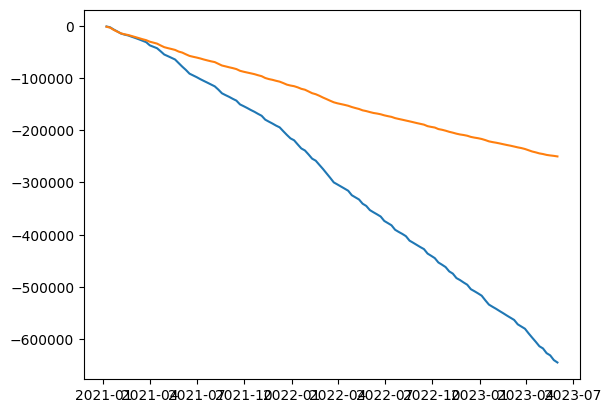

In [30]:
fig, ax = plt.subplots(1,1)
ax.plot(weekly_zip3_graphs.keys(), temporal_zip3_dm.hedge_total_regret[1:], label=
ax.plot(weekly_zip3_graphs.keys(), temporal_zip3_dm.naive_total_regret[1:])
ax.legend()

In [21]:
static_zip3_dm = WeeklyDecisionMaker()
for graph in tqdm(weekly_zip3_graphs.values()):
    static_zip3_dm.run_expert_simulation(graph, temporal=False, display_progress=True)

  0%|          | 0/126 [00:00<?, ?it/s]

** Sampled 336 positive and 336 negative edges. **


  0%|          | 0/126 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
temporal_kma_dm = WeeklyDecisionMaker()
for graph in tqdm(weekly_kma_graphs.values()):
    temporal_kma_dm.run_expert_simulation(graph, display_progress=True)

In [ ]:
static_kma_dm = WeeklyDecisionMaker()
for graph in tqdm(weekly_kma_graphs.values()):
    static_kma_dm.run_expert_simulation(graph, temporal=False, display_progress=True)

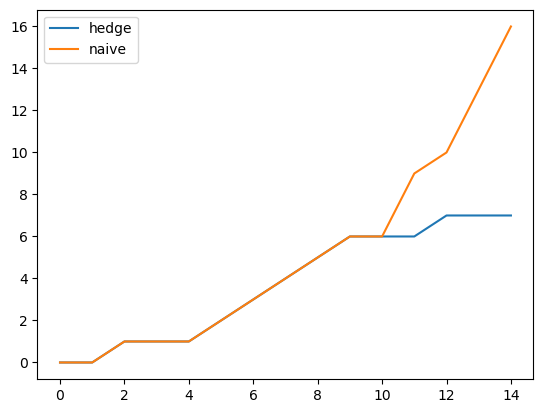

In [149]:
# show only increase in lp.target_regrets[('13', '60')]
increase_hedge_regret = []
test = lp.target_regrets[('13', '60')]
for i, x in enumerate(test):
    if i == 0: continue 
    if test[i-1] < x: 
        increase_hedge_regret.append(x-test[i-1])
    else: increase_hedge_regret.append(0)

increase_naive_regret = []
test = lp.naive_target_regrets[('13', '60')]
for i, x in enumerate(test):
    if i == 0: continue 
    if test[i-1] < x: 
        increase_naive_regret.append(x-test[i-1])
    else: increase_naive_regret.append(0)

plt.plot(np.arange(len(weight2) -1 ), np.cumsum(increase_hedge_regret), label='hedge')
plt.plot(np.arange(len(weight2) -1 ), np.cumsum(increase_naive_regret), label='naive')
plt.legend()

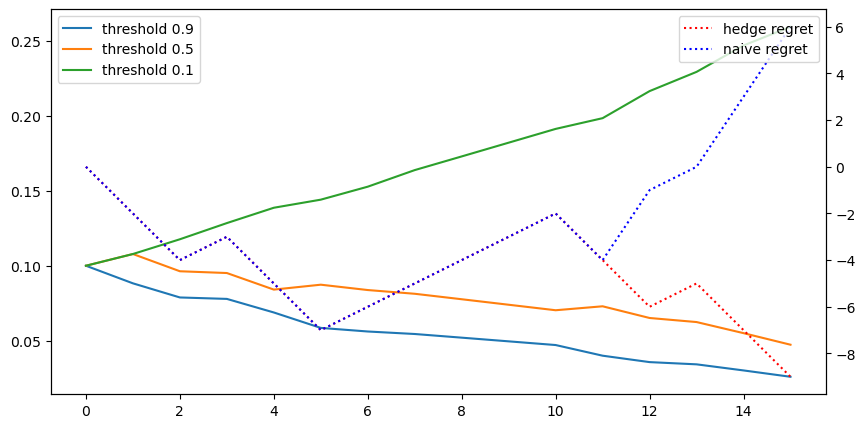

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
weight2 = np.array(lp.past_weight_vectors[('13', '60')])
ax.plot(np.arange(len(weight2)), weight2[:, 9], label=f'threshold 0.9')
ax.plot(np.arange(len(weight2)), weight2[:, 5], label=f'threshold 0.5')
ax.plot(np.arange(len(weight2)), weight2[:, 0], label=f'threshold 0.1')
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(np.arange(len(weight2)), lp.target_regrets[('13', '60')], label='hedge regret', color='r', linestyle=':')
ax2.plot(np.arange(len(weight2)), lp.naive_target_regrets[('13', '60')], label='naive regret', color='b', linestyle=':')
ax2.legend(loc='upper right')